In [1]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from keras.models import Model
from tensorflow import keras
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
system_random = random.SystemRandom()


In [42]:
qvector_source_train ='/content/drive/MyDrive/data/GENERATED_transaction_vectors_train.json'
qvector_source_test ='/content/drive/MyDrive/data/GENERATED_transaction_vectors_test.json'
#6180
#5360

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
cnn = keras.Sequential()
cnn.add(keras.layers.Input((6180,1)))
#cnn.add(keras.layers.Normalization(axis=None))
cnn.add(keras.layers.Conv1D(64,2,padding='same',activation='tanh'))
cnn.add(keras.layers.Conv1D(64,2,padding='same',activation='tanh'))
cnn.add(keras.layers.Conv1D(64,2,padding='same',activation='tanh'))
cnn.add(keras.layers.MaxPool1D(2,padding='same'))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(256,activation='relu'))
cnn.add(keras.layers.Dense(11,activation='softmax'))

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss ='categorical_crossentropy',metrics=['accuracy'])
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 6180, 64)          192       
                                                                 
 conv1d_37 (Conv1D)          (None, 6180, 64)          8256      
                                                                 
 conv1d_38 (Conv1D)          (None, 6180, 64)          8256      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 3090, 64)         0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 197760)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               50626816  
                                                      

In [5]:
def convertor(arr):
  result = np.zeros((len(arr),11))
  for i in range(0,len(result)):
    result[i,arr[i]-1]=1.0
  return result

In [6]:
def unpack_data(path):
    #transactions_list = []
    role_list = []
    query_list = []
    f = open(path, 'r', encoding='utf-8')
    data = json.load(f)
    print('len data ',len(data))
    for i in range(0,len(data)):
        #transactions_list.append(data[i].get('transaction'))
        role_list.append(data[i].get('role'))
        query_list.append(np.array(list(map(float,data[i].get('query')))))
    
    X = np.array(query_list)
    y = np.array(role_list)
    print(X)
    print(y)
    print(len(X))
    #print(transactions_list)
    print('unpacked')
    return X,y

In [7]:
def make_anomalies(y_test,percent):
    list1 = [1,2,3,4,5,6,7,8,9,10,11]
    count = int(len(y_test)*percent/100)
    print(f'Будет заменено {count}  первых значений ролей из {len(y_test)}, процент измененных {percent}.')
    y_test_anomalies = y_test.copy()
    for i in range(0,count):
        list2 = list1.copy()
        list2.remove(y_test_anomalies[i])
        y_test_anomalies[i] = system_random.choice(list2)
    return y_test_anomalies,count

In [8]:
def loss_plt(history):
  loss_values = history.history['loss']
  epochs = range(1, len(loss_values)+1)

  plt.plot(epochs, loss_values, label='Потери на обучающей выборке')
  plt.xlabel('Эпохи')
  plt.ylabel('Потери')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/data/loss.png')
  plt.show()

In [9]:
def accuracy_plt(history):
  acc_values = history.history['accuracy']
  epochs = range(1, len(acc_values)+1)

  plt.plot(epochs, acc_values, label='Точность на обучающей выборке',color='orange')
  plt.xlabel('Эпохи')
  plt.ylabel('Точность')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/data/accuracy.png')
  plt.show()

In [10]:
def plot_confusion_matrix(y_true,y_pred,name,vector_type):
    fig, ax = plt.subplots(figsize=(10,10))
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='OrRd')

    ax.set_title(' Матрица ошибок')
    ax.set_xlabel('Предсказанные значения классов')
    ax.set_ylabel(f'{name} значения классов')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    fig.savefig(f'{result_path}{vector_type}_confus_{name}.png')

In [44]:
classes = [1,2,3,4,5,6,7,8,9,10,11]
result_path = '/content/drive/MyDrive/data/results/'
X_train,y_train = unpack_data(qvector_source_train)
Q_DATA_LEN = len(y_train)
Q_VECTOR_LEN = len(X_train[0])
print(np.max(X_train,axis=1))
X_test, y_test = unpack_data(qvector_source_test)
y_train =  convertor(y_train)
Q_TEST_LEN=len(y_test)

len data  11000
[[  1. 109.   1. ...   0.   0.   0.]
 [  1. 177.   1. ...   0.   0.   0.]
 [  1. 202.   1. ...   0.   0.   0.]
 ...
 [  1. 120.   1. ...   0.   0.   0.]
 [  3.  56.   0. ...   0.   0.   0.]
 [  1. 376.   1. ...   0.   0.   0.]]
[ 1  2  3 ...  9 10 11]
11000
unpacked
[1.0900000e+02 1.8950400e+05 1.6981000e+04 ... 9.5706920e+06 3.4861000e+04
 1.2723526e+07]
len data  1100
[[  1. 115.   1. ...   0.   0.   0.]
 [  1. 113.   1. ...   0.   0.   0.]
 [  1. 156.   1. ...   0.   0.   0.]
 ...
 [  1. 178.   1. ...   0.   0.   0.]
 [  1.  62.   1. ...   0.   0.   0.]
 [  1. 230.   1. ...   0.   0.   0.]]
[ 1  2  3 ...  9 10 11]
1100
unpacked


In [ ]:
print(*X_train[4])

1.0 96.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.0 5.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

In [45]:
y_test_anomalies,count = make_anomalies(y_test,25)

Будет заменено 275  первых значений ролей из 1100, процент измененных 25.


In [46]:
norm = keras.layers.Normalization(axis=None)
norm.adapt(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1)))
history = cnn.fit(norm(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1))),y_train,epochs =20,shuffle=False)


Epoch 1/20
344/344 [==============================] - 16s 39ms/step - loss: 1.0914 - accuracy: 0.6203
Epoch 2/20
344/344 [==============================] - 14s 39ms/step - loss: 0.5414 - accuracy: 0.8014
Epoch 3/20
344/344 [==============================] - 14s 39ms/step - loss: 0.3332 - accuracy: 0.8767
Epoch 4/20
344/344 [==============================] - 13s 39ms/step - loss: 0.2280 - accuracy: 0.9144
Epoch 5/20
344/344 [==============================] - 13s 39ms/step - loss: 0.1620 - accuracy: 0.9395
Epoch 6/20
344/344 [==============================] - 13s 39ms/step - loss: 0.0960 - accuracy: 0.9639
Epoch 7/20
344/344 [==============================] - 13s 39ms/step - loss: 0.0766 - accuracy: 0.9708
Epoch 8/20
344/344 [==============================] - 13s 39ms/step - loss: 0.0523 - accuracy: 0.9813
Epoch 9/20
344/344 [==============================] - 13s 39ms/step - loss: 0.1189 - accuracy: 0.9691
Epoch 10/20
344/344 [==============================] - 13s 39ms/step - loss: 0.063

In [47]:
y_pred = cnn.predict(X_test.reshape((Q_TEST_LEN,Q_VECTOR_LEN,1,1)))
y=(np.argmax(y_pred,axis=1)+1)
print(*y)
m= keras.metrics.Accuracy()
m.update_state(y_test,(np.argmax(y_pred,axis=1)+1))
m.result().numpy()

35/35 [==============================] - 1s 13ms/step
1 8 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 8 8 9 10 11 1 8 3 3 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 7 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 3 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 11 1 2 3 4 7 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 10 7 8 9 10 11 1 3 3 4 5 8 7 8 9 10 7 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 10 7 8 9 10 7 1 2 3 4 5 6 7 8 9 10 11 1 8 3 3 5 6 7 8 9 10 7 1 2 3 4 5 6 7 8 9 10 7 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 7 1 2 3 3 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 3 3 4 5 6 7 8 9 10 7 1 2 3 3 5 6 7 8 9 10 11 1 2 3 3 5 8 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 7 1 2 3 3 7 6 7 8 9 10 7 1 2 3 3 5 6 7 8 9 10 7 1 2 3 3 7 6 7 

0.8772727

0.871901011267895
          precision    recall  f1-score
1          1.000000  1.000000  1.000000
2          0.840000  1.000000  0.913043
3          1.000000  0.584795  0.738007
4          0.360000  1.000000  0.529412
5          0.940000  0.989474  0.964103
6          0.830000  1.000000  0.907104
7          0.990000  0.722628  0.835443
8          1.000000  0.900901  0.947867
9          1.000000  0.990099  0.995025
10         1.000000  0.884956  0.938967
11         0.690000  1.000000  0.816568
accuracy   0.877273  0.877273  0.877273
[ 1  8  3  4  5  6  7  8  9 10 11  1  2  3  3  5  6  8  8  9 10 11  1  8
  3  3  5  6  7  8  9 10 11  1  2  3  3  5  6  7  8  9 10 11  1  2  3  3
  5 10  7  8  9 10  7  1  2  3  3  5  6  7  8  9 10 11  1  2  3  4  5  6
  7  8  9 10 11  1  2  3  4  5  6  7  8  9 10 11  1  3  3  4  5  6  7  8
  9 10 11  1  2  3  3  5  6  7  8  9 10 11  1  2  3  4  5  6  7  8  9 10
 11  1  2  3  3  5  6  7  8  9 10 11  1  2  3  4  5 10  7  8  9 10 11  1
  2  3  3  5  6  7  8  9

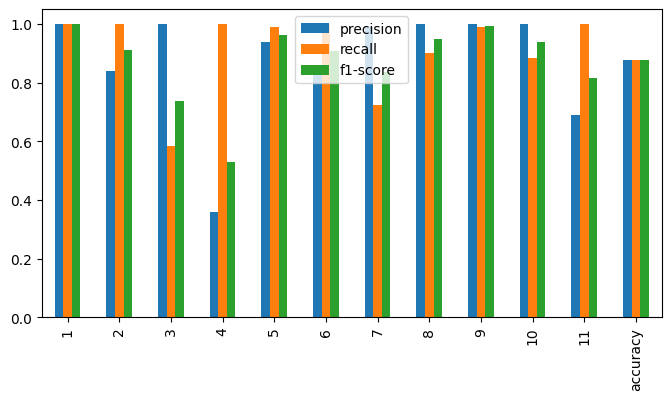

In [48]:
    report = classification_report(y, y_test,output_dict=True)
    df = pd.DataFrame(report).transpose()[:12]
    print(df['f1-score'].mean())
    df = df.drop('support', axis=1)
    print(df)
    df.plot( figsize= (8,4),kind='bar')


    anomalies_count = count
    print(y[:count])
    print(y_test_anomalies[:count])
    anomal_values = sum(el1 == el2 and el1 != el3 for el1, el2, el3 in zip(y[:count], y_test[:count], y_test_anomalies[:count]))
    detection_rate = (anomal_values / anomalies_count) * 100
    print('anomalies count ', anomalies_count)
    print('detection rate ', detection_rate)

    false_anomalies = sum(
        el1 != el2 and el1 != el3 for el1, el2, el3 in zip(y[:count], y_test[:count], y_test_anomalies[:count]))
    false_positive_rate = (false_anomalies / count) * 100
    print('false trigger', false_positive_rate)

    accuracy_score(y_test, y)
    print(f"The accuracy of the model is {round(accuracy_score(y_test, y), 3) * 100} %")
    # plot_confusion_matrix(y_test,y_pred,'Истинные',vector_type)
    # plot_confusion_matrix(y_test_anomalies[:count],y[:count],'Аномальные',vector_type)
    plt.show()

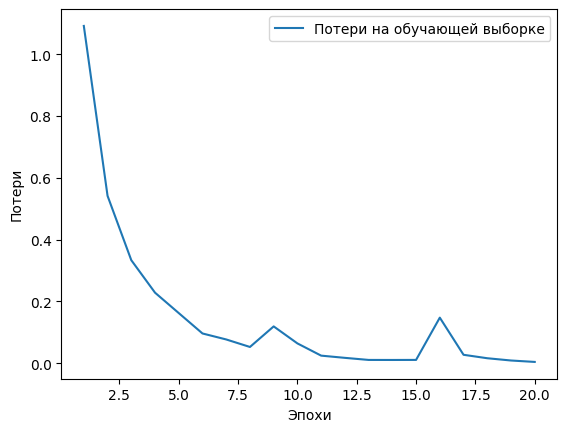

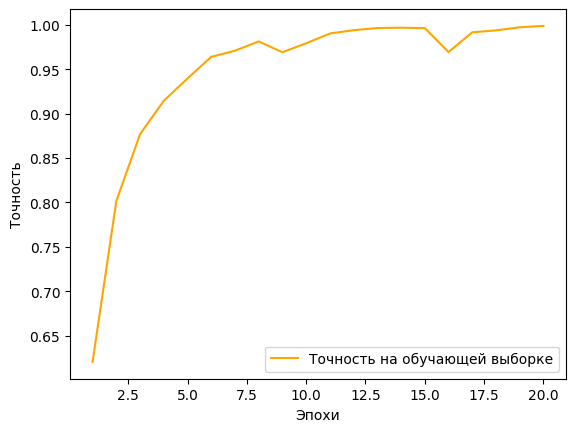

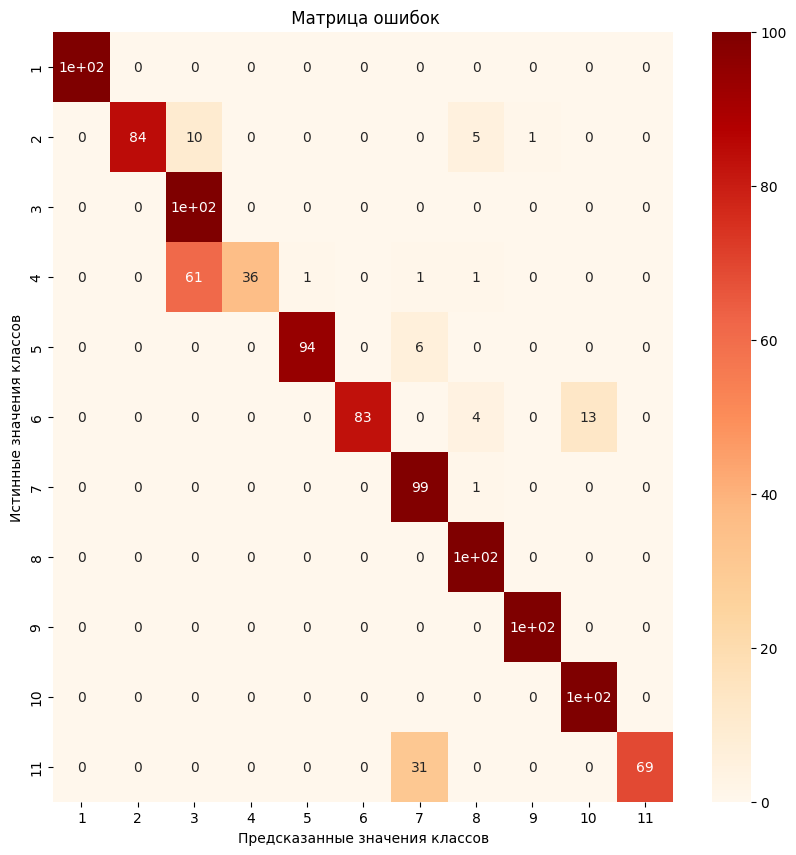

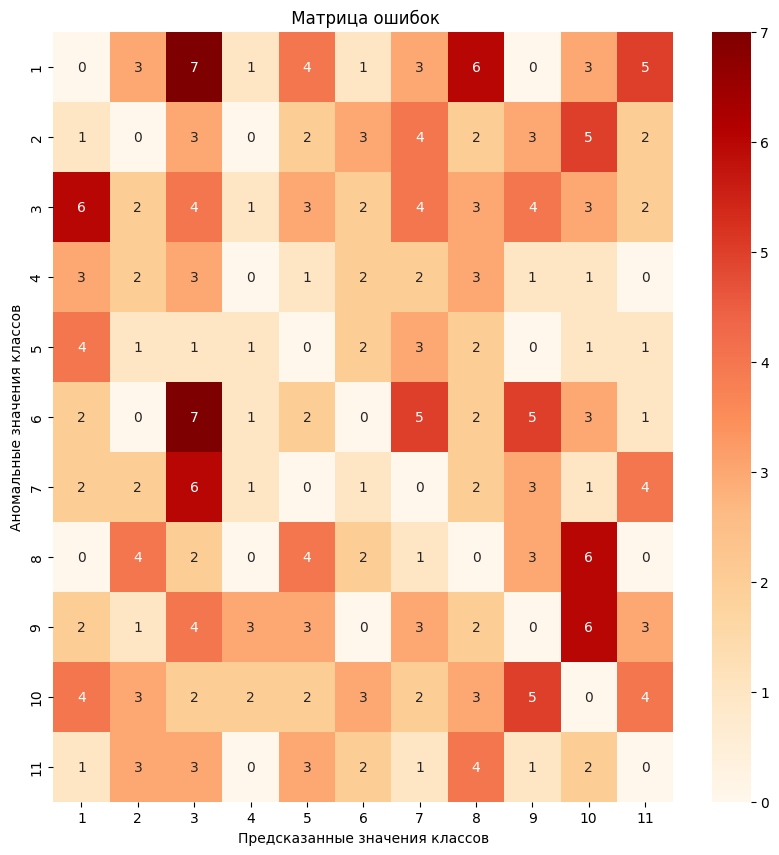

In [49]:
loss_plt(history)
accuracy_plt(history)

plot_confusion_matrix(y_test,y,'Истинные','new')
plot_confusion_matrix(y_test_anomalies[:anomalies_count],y[:anomalies_count],'Аномальные','new')


In [50]:
input = keras.layers.Input((6180,1))
o1 =keras.layers.Conv1D(32,2,padding='same',activation='tanh')(input)

o2 =keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o1)
o3=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o2)
o4=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o3)
o5=keras.layers.Conv1D(32,2,padding='same')(o4)
#out2 = res.layers[4].output + out
o15 = keras.activations.tanh(o1+o5)
o6=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o15)
o7=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o6)
o8=keras.layers.Conv1D(32,2,padding='same',activation='tanh')(o7)
o9=keras.layers.Conv1D(32,2,padding='same')(o8)
o159 = keras.activations.tanh(o1+o5+o9)
o10=keras.layers.MaxPool1D(2,padding='same')(o159)
o11=keras.layers.Flatten()(o10)
o12=keras.layers.Dense(256,activation='relu')(o11)
o13=keras.layers.Dense(11,activation='softmax')(o12)

model = tf.keras.Model(inputs=input, outputs=o13)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 6180, 1)]    0           []                               
                                                                                                  
 conv1d_39 (Conv1D)             (None, 6180, 32)     96          ['input_8[0][0]']                
                                                                                                  
 conv1d_40 (Conv1D)             (None, 6180, 32)     2080        ['conv1d_39[0][0]']              
                                                                                                  
 conv1d_41 (Conv1D)             (None, 6180, 32)     2080        ['conv1d_40[0][0]']              
                                                                                            

In [51]:
norm = keras.layers.Normalization(axis=None)
norm.adapt(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1)))
history2 = model.fit(norm(X_train.reshape((Q_DATA_LEN,Q_VECTOR_LEN,1))),y_train,epochs =5,shuffle=False)


Epoch 1/5
344/344 [==============================] - 21s 47ms/step - loss: 0.7985 - accuracy: 0.7190
Epoch 2/5
344/344 [==============================] - 16s 47ms/step - loss: 0.0429 - accuracy: 0.9831
Epoch 3/5
344/344 [==============================] - 16s 48ms/step - loss: 0.0123 - accuracy: 0.9949
Epoch 4/5
344/344 [==============================] - 16s 48ms/step - loss: 0.0105 - accuracy: 0.9968
Epoch 5/5
344/344 [==============================] - 16s 46ms/step - loss: 0.0111 - accuracy: 0.9965


In [55]:
y_pred = model.predict(X_test.reshape((Q_TEST_LEN,Q_VECTOR_LEN,1,1)))
y=(np.argmax(y_pred,axis=1)+1)
print(*y)
m= keras.metrics.Accuracy()
m.update_state(y_test,(np.argmax(y_pred,axis=1)+1))
m.result().numpy()

35/35 [==============================] - 1s 16ms/step
1 2 3 5 5 6 7 8 9 10 11 1 6 3 5 5 6 7 8 9 10 11 1 6 3 5 5 6 7 11 9 10 11 1 6 10 5 5 6 10 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 2 10 5 5 6 7 8 9 10 11 1 2 6 4 5 6 7 11 9 10 11 1 2 10 4 5 6 7 6 9 10 11 1 6 3 5 5 6 5 8 9 10 11 1 2 3 5 5 6 7 8 9 10 11 1 9 3 4 5 6 7 8 6 10 11 1 2 3 5 5 6 7 8 9 10 11 1 2 10 5 5 6 7 11 6 10 11 1 6 4 5 5 6 10 11 9 10 11 1 6 5 4 5 6 5 6 9 10 11 1 2 10 5 5 6 7 8 9 10 11 1 9 3 4 5 6 4 6 9 10 11 1 2 3 5 5 6 7 8 9 10 11 1 2 10 5 5 6 7 8 9 10 11 1 2 3 4 5 6 5 6 9 10 11 1 9 3 5 5 6 7 11 9 10 11 1 9 3 5 5 6 7 11 9 10 11 1 6 3 5 5 6 7 6 9 10 11 1 9 3 5 5 6 7 11 9 6 11 1 2 3 5 5 6 7 8 9 10 11 1 2 3 4 5 6 7 8 9 10 11 1 6 5 4 5 6 7 8 9 10 11 1 6 3 5 5 6 7 8 9 10 11 1 2 3 4 5 6 5 8 6 6 11 1 9 3 4 5 6 7 11 9 10 11 1 2 6 5 5 6 7 8 9 10 11 1 2 10 5 5 6 7 11 9 10 11 1 4 10 5 5 6 7 8 9 10 11 1 6 3 5 5 6 7 8 9 10 11 1 2 5 4 5 6 7 8 6 10 11 1 4 10 4 5 6 7 11 9 10 11 1 2 3 5 5 6 11 6 9 6 11 1 6 3 4 5 6 7 6 9 10 11 1 6 3 5 5 6 7 8

0.8090909

0.804600215216471
          precision    recall  f1-score
1          1.000000  1.000000  1.000000
2          0.500000  1.000000  0.666667
3          0.700000  1.000000  0.823529
4          0.420000  0.857143  0.563758
5          1.000000  0.588235  0.740741
6          1.000000  0.578035  0.732601
7          0.860000  1.000000  0.924731
8          0.650000  1.000000  0.787879
9          0.840000  0.831683  0.835821
10         0.930000  0.794872  0.857143
11         1.000000  0.840336  0.913242
accuracy   0.809091  0.809091  0.809091
[ 1  2  3  5  5  6  7  8  9 10 11  1  6  3  5  5  6  7  8  9 10 11  1  6
  3  5  5  6  7 11  9 10 11  1  6 10  5  5  6 10  8  9 10 11  1  2  3  4
  5  6  7  8  9 10 11  1  2 10  5  5  6  7  8  9 10 11  1  2  6  4  5  6
  7 11  9 10 11  1  2 10  4  5  6  7  6  9 10 11  1  6  3  5  5  6  5  8
  9 10 11  1  2  3  5  5  6  7  8  9 10 11  1  9  3  4  5  6  7  8  6 10
 11  1  2  3  5  5  6  7  8  9 10 11  1  2 10  5  5  6  7 11  6 10 11  1
  6  4  5  5  6 10 11  9

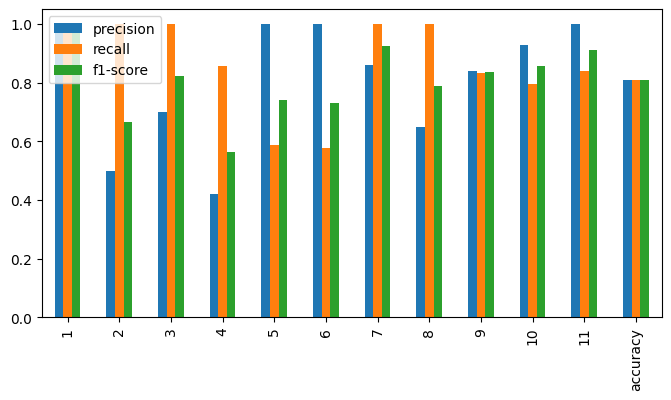

In [56]:
    report = classification_report(y, y_test,output_dict=True)
    df = pd.DataFrame(report).transpose()[:12]
    print(df['f1-score'].mean())
    df = df.drop('support', axis=1)
    print(df)
    df.plot( figsize= (8,4),kind='bar')


    anomalies_count = count
    print(y[:count])
    print(y_test_anomalies[:count])
    anomal_values = sum(el1 == el2 and el1 != el3 for el1, el2, el3 in zip(y[:count], y_test[:count], y_test_anomalies[:count]))
    detection_rate = (anomal_values / anomalies_count) * 100
    print('anomalies count ', anomalies_count)
    print('detection rate ', detection_rate)

    false_anomalies = sum(
        el1 != el2 and el1 != el3 for el1, el2, el3 in zip(y[:count], y_test[:count], y_test_anomalies[:count]))
    false_positive_rate = (false_anomalies / count) * 100
    print('false trigger', false_positive_rate)

    accuracy_score(y_test, y)
    print(f"The accuracy of the model is {round(accuracy_score(y_test, y), 3) * 100} %")
    # plot_confusion_matrix(y_test,y_pred,'Истинные',vector_type)
    # plot_confusion_matrix(y_test_anomalies[:count],y[:count],'Аномальные',vector_type)
    plt.show()

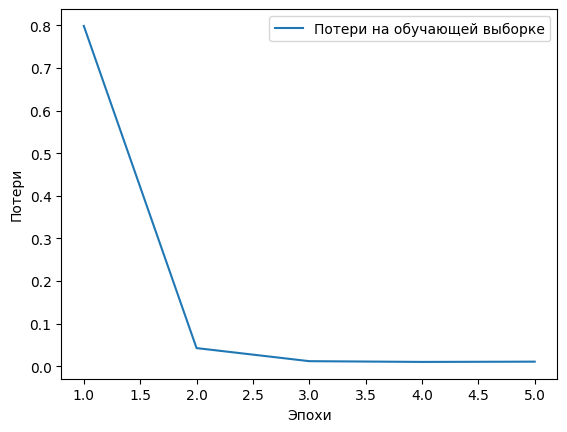

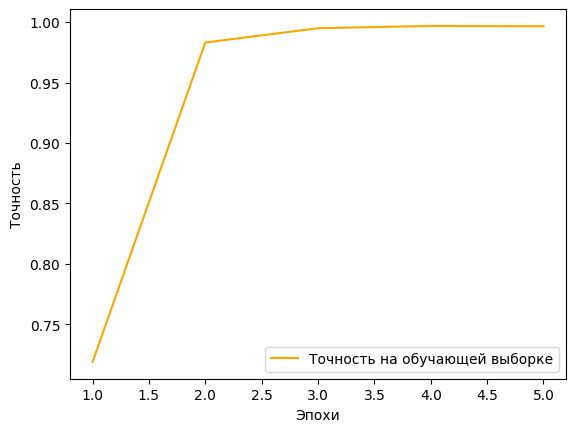

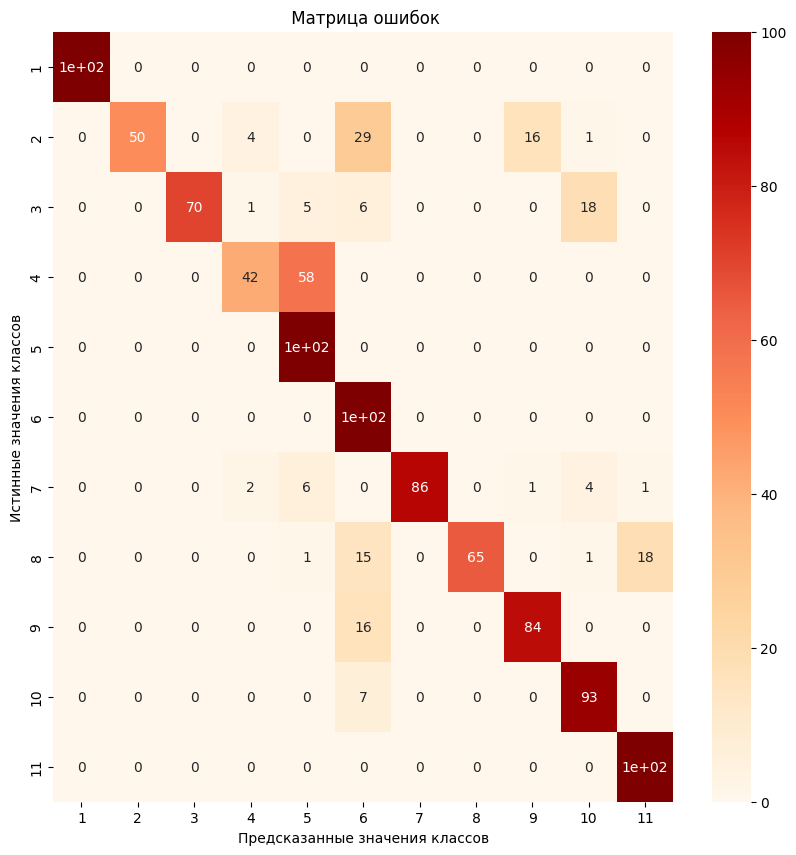

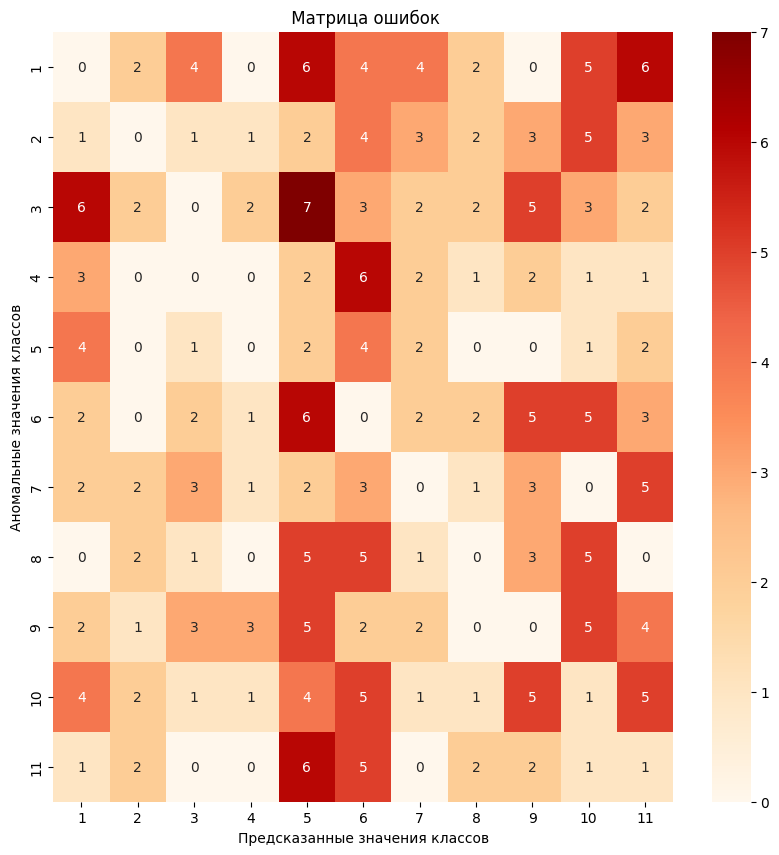

In [57]:
loss_plt(history2)
accuracy_plt(history2)

plot_confusion_matrix(y_test,y,'Истинные','new')
plot_confusion_matrix(y_test_anomalies[:anomalies_count],y[:anomalies_count],'Аномальные','new')